In [19]:
import os

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

In [5]:
path = r'Z:\IO3-sessions\NEW STRUCTURE\de-earlyfusionthesis\Datasets'

train_dataset_path_I = os.path.abspath(os.path.join(path, 'train_dataset_method_I_balanced'))
GUT_test_path_I = os.path.join(path, 'GUT_test_method_I_balanced').replace("\\", "/")
ITU_YU_test_path_I = os.path.join(path, 'ITU_YU_test_method_I_balanced').replace("\\", "/")
MAAP_test_path_I = os.path.join(path, 'MAAP_test_method_I_balanced').replace("\\", "/")

train_dataset_path_II = os.path.abspath(os.path.join(path, 'train_dataset_method_II_balanced'))
GUT_test_path_II = os.path.join(path, 'GUT_test_method_II_balanced').replace("\\", "/")
ITU_YU_test_path_II = os.path.join(path, 'ITU_YU_test_method_II_balanced').replace("\\", "/")
MAAP_test_path_II = os.path.join(path, 'MAAP_test_method_II_balanced').replace("\\", "/")

# Load datasets
train_I = tf.data.Dataset.load(train_dataset_path_I)
GUT_test_I = tf.data.Dataset.load(GUT_test_path_I)
ITU_YU_test_I = tf.data.Dataset.load(ITU_YU_test_path_I)
MAAP_test_I = tf.data.Dataset.load(MAAP_test_path_I)

train_II = tf.data.Dataset.load(train_dataset_path_II)
GUT_test_II = tf.data.Dataset.load(GUT_test_path_II)
ITU_YU_test_II = tf.data.Dataset.load(ITU_YU_test_path_II)
MAAP_test_II = tf.data.Dataset.load(MAAP_test_path_II)

full_test_I = GUT_test_I.concatenate(ITU_YU_test_I).concatenate(MAAP_test_I)
full_test_II = GUT_test_II.concatenate(ITU_YU_test_II).concatenate(MAAP_test_II)

In [9]:
emotions = ['Happy', 'Sad', 'Scared', 'Disgusted', 'Surprised', 'Angry']

## MODEL I

In [8]:
def masked_categorical_crossentropy(y_true, y_pred):
    """
    y_true: true labels, one-hot encoded. Shape (batch_size, sequence_length, OUTPUT_DIM)
    y_pred: predicted probabilities. Shape (batch_size, sequence_length, OUTPUT_DIM)
    """
    # Create a mask: 1 for valid labels (non-[0, 0, 0]), 0 for "Unknown" ([0, 0, 0])
    mask = tf.reduce_sum(y_true, axis=-1) > 0  # Shape: (batch_size, sequence_length)
    mask = tf.cast(mask, tf.float32)  # Convert boolean mask to float32 for multiplication
    
    # Compute categorical cross-entropy loss
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    # Apply the mask to the loss
    loss = loss * mask  # Zero out loss for "Unknown" labels
    
    # Return mean loss over valid labels
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [10]:
model_method_I = tf.keras.models.load_model('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/Models/model_method_I/model.keras', custom_objects={ 'masked_categorical_crossentropy': masked_categorical_crossentropy})

In [16]:
import keras
# Save and display the model architecture
keras.utils.plot_model(model_method_I, rankdir='TB', show_shapes=True, show_layer_names=True, show_layer_activations=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [17]:
model_method_I.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 20, 128)        │       296,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 922,484 (3.52 MB)

 Trainable params: 307,494 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 614,990 (2.35 MB)

In [52]:
test_set = full_test_I
# Getting predictions (chat)
y_pred = model_method_I.predict(test_set.map(lambda x, _: x))
y_true = tf.concat([y for _, y in test_set], axis=0)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step


In [18]:
y_true_flat = tf.reshape(y_true, [-1, 6]).numpy()  # Shape: (112*20, 6)
y_pred_flat = y_pred.reshape(-1, 6)  # Shape: (112*20, 6)
valid_indices = np.where(np.sum(y_true_flat, axis=-1) > 0)  # Find indices where y_true is not Neutral

# Apply the valid indices to both y_pred_labels and y_true_labels
y_pred_valid = y_pred_flat[valid_indices]
y_true_valid = y_true_flat[valid_indices]  

In [19]:
categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()
categorical_accuracy.update_state(y_true_valid, y_pred_valid)
print(f"Categorical Accuracy: {categorical_accuracy.result().numpy()}")

Categorical Accuracy: 0.8356643319129944


In [20]:
y_true_indices = np.argmax(y_true.numpy(), axis=-1).flatten()
y_pred_indices = np.argmax(y_pred, axis=-1).flatten()

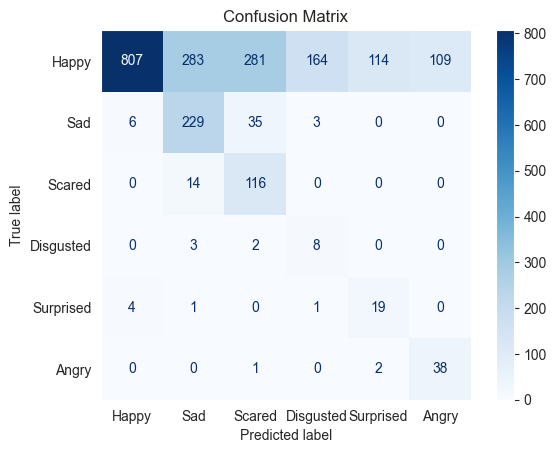

In [21]:
cm = confusion_matrix(y_true_indices, y_pred_indices)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
disp.plot(cmap='Blues', values_format='')
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

In [23]:
from sklearn.metrics import roc_curve, auc
# Initialize plot
plt.figure(figsize=(10, 8))
# Iterate over each class to calculate and plot ROC curve
for i, emotion in enumerate(emotions):
    # Get true binary labels and predicted scores for this class
    y_true_binary = y_true_valid[:, i]
    y_pred_binary_scores = y_pred_valid[:, i]
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{emotion} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

NameError: name 'y_true_valid' is not defined

<Figure size 1000x800 with 0 Axes>

In [3]:
def get_valid_indices(test_set):
    y_pred = model_method_I.predict(test_set.map(lambda x, _: x))
    y_true = tf.concat([y for _, y in test_set], axis=0)

    # Convert predictions to the most likely emotion (class with max probability)
    y_pred_labels = np.argmax(y_pred, axis=-1)  # Shape: (num_samples,)
    y_true_labels = np.argmax(y_true, axis=-1)  # Shape: (num_samples,)

    # Filter out Neutral labels (where y_true is [0, 0, 0, 0, 0, 0])
    valid_indices = np.where(np.sum(y_true, axis=-1) > 0)  # Find indices where y_true is not Neutral

    # Apply the valid indices to both y_pred_labels and y_true_labels
    y_pred_valid = y_pred_labels[valid_indices]
    y_true_valid = y_true_labels[valid_indices]

    return y_true_valid, y_pred_valid

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


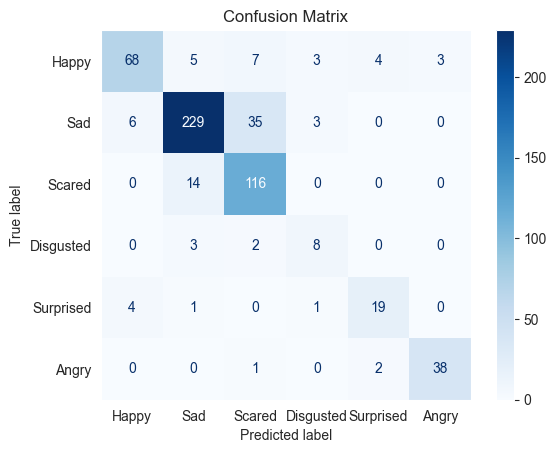

In [206]:
y_true, y_pred = get_valid_indices(full_test_I)

# Compute confusion matrix using valid labels
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
disp.plot(cmap='Blues', values_format='')
plt.grid(False)
plt.title("Confusion Matrix")
plt.savefig('Method_I_Confusion_Matrix.png', dpi=300)
plt.show()


In [201]:
from sklearn.metrics import roc_curve, auc

for i, emotion in enumerate(emotions):
    # Get true binary labels and predicted scores for this emotion
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{emotion} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Emotions')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

ValueError: multiclass format is not supported

In [107]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def calculate_emotion_metrics(y_true, y_pred, emotions):
    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(emotions)))

    metrics = []

    # Total number of samples
    total_samples = len(y_true)

    # Initialize totals for Micro-average
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0
    total_true_negatives = 0

    for i, emotion in enumerate(emotions):
        # Extract counts from confusion matrix for class i
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)

        # Calculate accuracy
        accuracy = (tp + tn) / total_samples

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Append metrics for this emotion
        metrics.append({
            'Emotion': emotion,
            'True Positive': tp,
            'True Negative': tn,
            'False Positive': fp,
            'False Negative': fn,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Accuracy': accuracy
        })

        # Accumulate totals for micro-average
        total_true_positives += tp
        total_false_positives += fp
        total_false_negatives += fn
        total_true_negatives += tn

    # Calculate micro-average
    micro_precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    micro_recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0
    micro_accuracy = (total_true_positives + total_true_negatives) / total_samples

    # Add micro-average metrics to the list
    metrics.append({
        'Emotion': 'Micro-average',
        'True Positive': total_true_positives,
        'True Negative': total_true_negatives,
        'False Positive': total_false_positives,
        'False Negative': total_false_negatives,
        'Precision': micro_precision,
        'Recall': micro_recall,
        'F1-Score': micro_f1,
        'Accuracy': micro_accuracy
    })

    # Calculate macro-average
    macro_precision = np.mean([m['Precision'] for m in metrics[:-1]])  # Exclude micro-average
    macro_recall = np.mean([m['Recall'] for m in metrics[:-1]])       # Exclude micro-average
    macro_f1 = np.mean([m['F1-Score'] for m in metrics[:-1]])         # Exclude micro-average
    macro_accuracy = np.mean([m['Accuracy'] for m in metrics[:-1]])   # Exclude micro-average

    # Add macro-average metrics to the list
    metrics.append({
        'Emotion': 'Macro-average',
        'True Positive': total_true_positives,
        'True Negative': total_true_negatives,
        'False Positive': total_false_positives,
        'False Negative': total_false_negatives,
        'Precision': macro_precision,
        'Recall': macro_recall,
        'F1-Score': macro_f1,
        'Accuracy': macro_accuracy
    })

    # Convert metrics to DataFrame
    df = pd.DataFrame(metrics)
    return df


In [106]:
from PIL import Image
import os
directory = r'C:\StudiaMoje\Semestr6\ProjektInżynierski\673315931e94a3f31283d2f2\figures'
img = Image.open(os.path.join(directory, "folder_tree.png"))
img = img.resize((int(img.size[0]/2),int(img.size[1]/2)), 0)
img.save(os.path.join(directory, "folder_tree.png"))

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_emotion_metrics(df, output_path="Plots/Emotion_Metrics.png", institution='Total'):
    # Exclude 'Micro-average' and 'Macro-average'
    emotions = df['Emotion'][:-2].tolist()

    # Prepare data
    metrics = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
    metric_percentages = []

    for metric in metrics:
        percentages = []
        for emotion in emotions:
            # Get the value for this metric and emotion
            value = df.loc[df['Emotion'] == emotion, metric].values[0]

            # Calculate total instances for this emotion
            total_instances = (
                    df.loc[df['Emotion'] == emotion, 'True Positive'].values[0] +
                    df.loc[df['Emotion'] == emotion, 'True Negative'].values[0] +
                    df.loc[df['Emotion'] == emotion, 'False Positive'].values[0] +
                    df.loc[df['Emotion'] == emotion, 'False Negative'].values[0]
            )

            # Calculate percentage
            percentages.append((value / total_instances) * 100)

        metric_percentages.append(percentages)

    # Create the plot
    plt.figure(figsize=(12, 6), dpi=150)

    # Set width of bars
    bar_width = 0.2

    # Set positions of bars on X axis
    r1 = np.arange(len(emotions))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]

    # Create bars
    plt.bar(r1, metric_percentages[0], color='green', width=bar_width, label='True Positive')
    plt.bar(r2, metric_percentages[1], color='blue', width=bar_width, label='True Negative')
    plt.bar(r3, metric_percentages[2], color='red', width=bar_width, label='False Positive')
    plt.bar(r4, metric_percentages[3], color='orange', width=bar_width, label='False Negative')

    # Add labels and title
    plt.xlabel('Emotions', fontsize=12)
    plt.ylabel('Percentage of Total (%)', fontsize=12)
    plt.title(f'Emotion Metrics Distribution for {institution}', fontsize=14)

    # Add xticks on the middle of the group bars
    plt.xticks([r + bar_width*1.5 for r in range(len(emotions))], emotions, rotation=45, ha='right')

    # Create legend
    plt.legend()

    # Set y-axis to go from 0 to 100
    plt.ylim(0, 100)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(output_path, dpi=1200)
    plt.show()

In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def plot_emotion_metrics_heatmap(df, output_path="Plots/Emotion_Metrics_Heatmap.png", institution='Total'):
    # Exclude 'Micro-average' and 'Macro-average'
    emotions = df['Emotion'][:-2].tolist()

    # Prepare data: Extract metrics and organize them into a DataFrame
    metrics = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
    metric_percentages = []

    for metric in metrics:
        percentages = []
        for emotion in emotions:
            # Get the value for this metric and emotion
            value = df.loc[df['Emotion'] == emotion, metric].values[0]

            # Calculate total instances for this emotion
            total_instances = (
                    df.loc[df['Emotion'] == emotion, 'True Positive'].values[0] +
                    df.loc[df['Emotion'] == emotion, 'True Negative'].values[0] +
                    df.loc[df['Emotion'] == emotion, 'False Positive'].values[0] +
                    df.loc[df['Emotion'] == emotion, 'False Negative'].values[0]
            )

            # Calculate percentage
            percentages.append((value / total_instances) * 100)

        metric_percentages.append(percentages)

    # Convert the list to a DataFrame for better manipulation
    heatmap_data = pd.DataFrame(metric_percentages, index=metrics, columns=emotions)

    # Create the heatmap plot
    plt.figure(figsize=(12, 6), dpi=150)

    # Use seaborn to plot the heatmap
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Percentage of Total (%)'}, fmt=".2f",
                linewidths=0.5, linecolor='gray')

    # Add labels and title
    plt.xlabel('Emotions', fontsize=12)
    plt.ylabel('Metrics', fontsize=12)
    plt.title(f'Emotion Metrics Distribution for {institution}', fontsize=14)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(output_path, dpi=1200)
    plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step


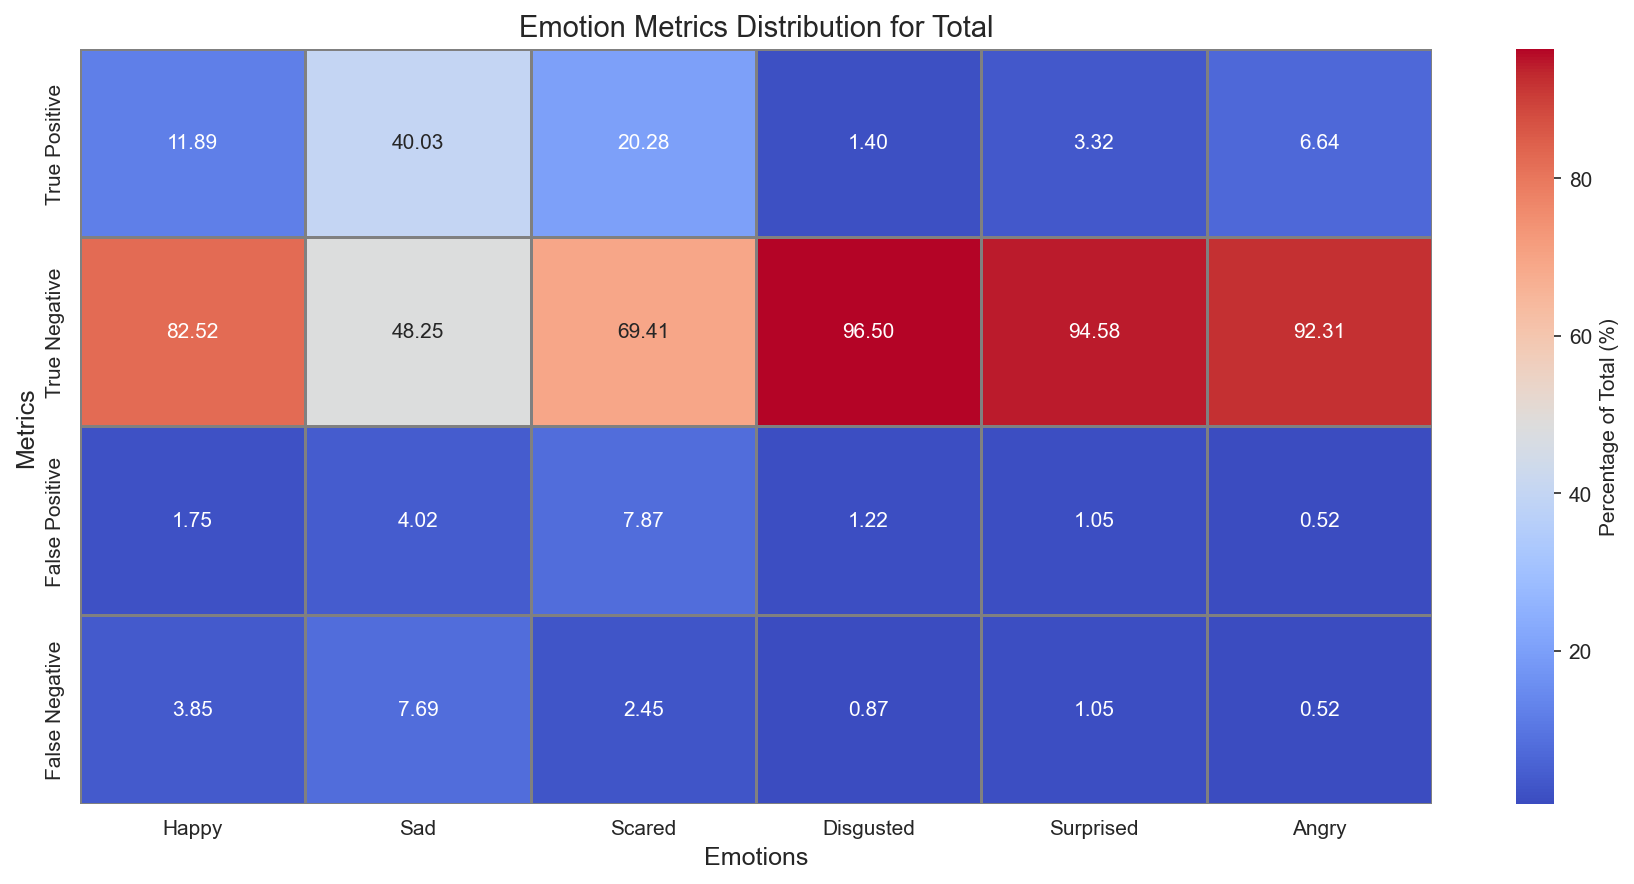

In [102]:
y_true, y_pred = get_valid_indices(full_test_I)
metrics = calculate_emotion_metrics(y_true, y_pred, emotions)
plot_emotion_metrics_heatmap(metrics, output_path="Plots/Method_I_Heatmap_Full.png", institution='Total')

In [71]:
y_true, y_pred = get_valid_indices(full_test_I)
metrics = calculate_emotion_metrics(y_true, y_pred, emotions)
plot_emotion_metrics(metrics, output_path="Plots/Emotion_MetricsTotal.png", institution='Total')

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step


In [108]:
def export_metrics_to_latex(metrics_df, output_file='emotion_metrics.tex'):
    """
    Export emotion metrics to a LaTeX table
    
    Args:
        metrics_df (pd.DataFrame): DataFrame with emotion metrics
        output_file (str): Path to save the LaTeX table
    """
    # Select relevant columns
    display_columns = ['Emotion', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

    # Prepare the table
    latex_table = metrics_df[display_columns].copy()

    # Round numeric columns to 4 decimal places
    numeric_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    for col in numeric_cols:
        latex_table[col] = latex_table[col].apply(lambda x: f'{x:.4f}')

    # Convert to LaTeX
    latex_output = latex_table.to_latex(
        index=False,
        float_format='{:.4f}'.format,
        column_format='l' + 'c' * (len(display_columns) - 1)
    )

    # Write to file
    with open(output_file, 'w') as f:
        f.write(latex_output)

    return latex_output

In [109]:
y_true, y_pred = get_valid_indices(GUT_test_I)
metrics = calculate_emotion_metrics(y_true, y_pred, emotions)
print(metrics)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
         Emotion  True Positive  True Negative  False Positive  \
0          Happy              1             11               0   
1            Sad              8              1               3   
2         Scared              0             12               0   
3      Disgusted              0              9               0   
4      Surprised              0             12               0   
5          Angry              0             12               0   
6  Micro-average              9             57               3   
7  Macro-average              9             57               3   

   False Negative  Precision    Recall  F1-Score  Accuracy  
0               0   1.000000  1.000000  1.000000  1.000000  
1               0   0.727273  1.000000  0.842105  0.750000  
2               0   0.000000  0.000000  0.000000  1.000000  
3               3   0.000000  0.000000  0.000000  0.750000  
4               0   0.000000  0.000000  0.000000  1.000000  


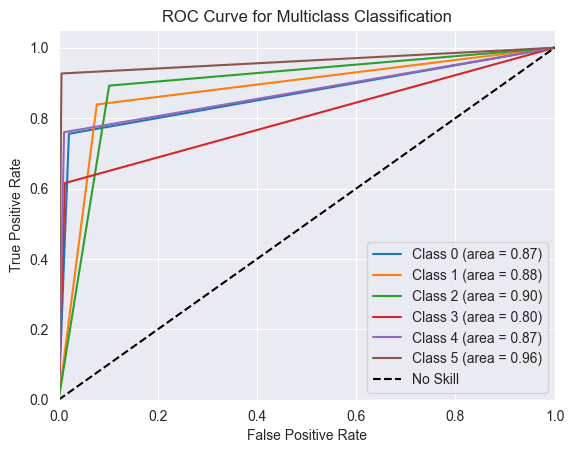

{'fpr': {0: array([0.        , 0.02074689, 1.        ]),
  1: array([0.        , 0.07692308, 1.        ]),
  2: array([0.        , 0.10180995, 1.        ]),
  3: array([0.        , 0.01252236, 1.        ]),
  4: array([0.        , 0.01096892, 1.        ]),
  5: array([0.        , 0.00564972, 1.        ])},
 'tpr': {0: array([0.        , 0.75555556, 1.        ]),
  1: array([0.        , 0.83882784, 1.        ]),
  2: array([0.        , 0.89230769, 1.        ]),
  3: array([0.        , 0.61538462, 1.        ]),
  4: array([0.  , 0.76, 1.  ]),
  5: array([0.        , 0.92682927, 1.        ])},
 'roc_auc': {0: 0.8674043337943752,
  1: 0.880952380952381,
  2: 0.8952488687782805,
  3: 0.8014311270125224,
  4: 0.8745155393053016,
  5: 0.9605897753892794}}

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc(y_true, y_pred, title="ROC Curve for Multiclass Classification"):
    """
    Plot ROC curves for multiclass classification using a one-vs-rest approach.

    Args:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels (or probabilities).
        title (str): Title for the ROC plot.

    Returns:
        dict: Dictionary containing fpr, tpr, and roc_auc values for each class.
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Identify unique classes
    classes = np.unique(y_true)
    n_classes = len(classes)

    # Binarize the labels for multiclass ROC computation
    y_true_binarized = label_binarize(y_true, classes=classes)
    y_pred_binarized = label_binarize(y_pred, classes=classes)

    # Compute ROC curve and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(
            fpr[i],
            tpr[i],
            label=f"Class {classes[i]} (area = {roc_auc[i]:0.2f})"
        )

    # Plot the diagonal
    plt.plot([0, 1], [0, 1], "k--", label="No Skill")

    # Format the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

    # Return the metrics for further use
    return {"fpr": fpr, "tpr": tpr, "roc_auc": roc_auc}
plot_multiclass_roc(y_true, y_pred)

## MODEL II

In [28]:
def masked_mean_squared_error(y_true, y_pred):
    """
    y_true: true labels, one-hot encoded. Shape (batch_size, sequence_length, OUTPUT_DIM)
    y_pred: predicted probabilities. Shape (batch_size, sequence_length, OUTPUT_DIM)
    """
    # Create a mask: 1 for valid labels (non-[0, 0, 0]), 0 for "Unknown" ([0, 0, 0])
    mask = tf.reduce_sum(y_true, axis=-1) > 0  # Shape: (batch_size, sequence_length)
    mask = tf.cast(mask, tf.float32)  # Convert boolean mask to float32 for multiplication
    
    # Compute categorical cross-entropy loss
    loss = tf.square(y_true - y_pred)
    
    # Apply the mask to the loss
    loss = loss * mask[..., tf.newaxis]  # Zero out loss for "Unknown" labels
    
    # Return mean loss over valid labels
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [29]:
model_method_II = tf.keras.models.load_model(
    '//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/Models/model_method_II/model.keras', custom_objects={"masked_mean_squared_error": masked_mean_squared_error})

In [30]:
model_method_II.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 256)        │       659,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,108,660 (8.04 MB)

 Trainable params: 702,886 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,405,774 (5.36 MB)

In [179]:
test_set = full_test_II
# Getting predictions (chat)
y_pred = model_method_II.predict(test_set.map(lambda x, _: x))
y_true = tf.concat([y for _, y in test_set], axis=0)
# Helper function to compute metrics for a single emotion
def compute_all_metrics(y_true, y_pred):
    """
    Compute MAS, MSE, MAE, RMSE, and R² for masked values of y_true and y_pred.
    
    Args:
        y_true (tf.Tensor): Ground truth values after masking.
        y_pred (tf.Tensor): Predicted values after masking.
    
    Returns:
        dict: A dictionary with computed metrics.
    """
    def compute_mse(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred)).numpy()

    def compute_mae(y_true, y_pred):
        return tf.reduce_mean(tf.abs(y_true - y_pred)).numpy()

    def compute_rmse(y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        return tf.sqrt(mse).numpy()

    def compute_similarity(y_true, y_pred):
        similarity = 1 - tf.abs(y_true - y_pred)
        mas = tf.reduce_mean(similarity).numpy()
        label_count = tf.size(y_true).numpy()
        return mas, label_count

    # Compute metrics
    mse = compute_mse(y_true, y_pred)
    mae = compute_mae(y_true, y_pred)
    rmse = compute_rmse(y_true, y_pred)
    mas, label_count = compute_similarity(y_true, y_pred)

    return {
        'Labels Used': label_count,
        'Similarity': mas,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    }

# Main function to compute metrics for all emotions
def compute_metrics_for_all_emotions_with_neutral_metric(y_true, y_pred, emotions):
    metric_results = []
    neutral_sums = []

    # Identify neutral rows in y_true (all emotions are 0)
    neutral_mask = tf.reduce_all(tf.equal(y_true, 0), axis=-1)  # Shape: [batch_size, sequence_length]

    for i, emotion in enumerate(emotions):
        true_values = tf.cast(y_true[:, :, i], tf.float32)
        pred_values = tf.cast(y_pred[:, :, i], tf.float32)

        mask_nonzero = tf.not_equal(true_values, 0)
        true_values_masked = tf.boolean_mask(true_values, mask_nonzero)
        pred_values_masked = tf.boolean_mask(pred_values, mask_nonzero)

        metrics = compute_all_metrics(true_values_masked, pred_values_masked)
        metrics['emotion'] = emotion

        # Neutral-based metric for this emotion
        pred_values_neutral = tf.boolean_mask(pred_values, neutral_mask)
        neutral_mask_count = tf.reduce_sum(tf.cast(neutral_mask, tf.float32))  # Cast to float32
        if tf.size(pred_values_neutral) > 0:
            neutral_sum = 1 - (tf.reduce_sum(pred_values_neutral).numpy() / neutral_mask_count.numpy())
        else:
            neutral_sum = 1
        neutral_sums.append(neutral_sum)
        metrics['neutral_sum'] = neutral_sum

        metric_results.append(metrics)
        print(f"Metrics for emotion {emotion}: {metrics}")

    # Compute overall metrics
    total_labels = sum([m['Labels Used'] for m in metric_results])
    avg_similarity = sum([m['Similarity'] for m in metric_results]) / len(metric_results)
    avg_mse = sum([m['MSE'] for m in metric_results]) / len(metric_results)
    avg_mae = sum([m['MAE'] for m in metric_results]) / len(metric_results)
    avg_rmse = sum([m['RMSE'] for m in metric_results]) / len(metric_results)
    overall_neutral_metric = sum(neutral_sums) / len(neutral_sums)

    overall_metrics = {
        'Labels Used': total_labels,
        'Similarity': avg_similarity,
        'MSE': avg_mse,
        'MAE': avg_mae,
        'RMSE': avg_rmse,
        'emotion': 'Overall',
        'neutral_sum': overall_neutral_metric
    }

    print(f"Overall Metrics: {overall_metrics}")
    metric_results.append(overall_metrics)

    return metric_results




# Example Usage
# Assuming `emotions` is a list of emotion names, and `y_true` and `y_pred` are already defined
results = compute_metrics_for_all_emotions_with_neutral_metric(y_true, y_pred, emotions)

# Results are already printed inside the loop


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step
Metrics for emotion Happy: {'Labels Used': 1431, 'Similarity': 0.7898001, 'MSE': 0.076908715, 'MAE': 0.21019985, 'RMSE': 0.2773242, 'emotion': 'Happy', 'neutral_sum': 0.782221332192421}
Metrics for emotion Sad: {'Labels Used': 931, 'Similarity': 0.82051045, 'MSE': 0.059334498, 'MAE': 0.1794896, 'RMSE': 0.24358673, 'emotion': 'Sad', 'neutral_sum': 0.9188287779688835}
Metrics for emotion Scared: {'Labels Used': 696, 'Similarity': 0.84736335, 'MSE': 0.036517054, 'MAE': 0.15263668, 'RMSE': 0.19109435, 'emotion': 'Scared', 'neutral_sum': 0.9530203752219677}
Metrics for emotion Disgusted: {'Labels Used': 318, 'Similarity': 0.80253, 'MSE': 0.052576303, 'MAE': 0.19747002, 'RMSE': 0.22929524, 'emotion': 'Disgusted', 'neutral_sum': 0.9258588701486588}
Metrics for emotion Surprised: {'Labels Used': 202, 'Similarity': 0.8049986, 'MSE': 0.05715695, 'MAE': 0.19500145, 'RMSE': 0.2390752, 'emotion': 'Surprised', 'neutral_sum': 0.9691042080521584}
Metrics for emot

In [180]:
import os

def save_latex_table_from_metric_results(metric_results, institution_name):
    """
    Generate and save a LaTeX table from the metric results produced by 
    `compute_metrics_for_all_emotions_with_neutral_metric`.

    Args:
        metric_results (list of dicts): Metrics list including each emotion and overall results.
        institution_name (str): Name of the institution to include in the table caption.

    Saves:
        A LaTeX file in the `LatexTables` directory with the table.
    """
    # Start the LaTeX table as a regular formatted string (f-string)
    latex_table = f"""
\\begin{{table}}[!ht]
    \\centering
    \\small
    \\caption{{Metrics for Emotion Classification for {institution_name}}}
    \\label{{tbl:metrics{institution_name.lower().replace(' ', '')}}}
    \\begin{{tblr}}{{%
        hlines,%
        vlines,%
        row{{1}}={{font=\\bfseries}},%
        column{{1}}={{halign=c}},%
    }}%
        Emotion       & Labels Used & Similarity & MSE    & MAE    & RMSE   & Neutral Metric \\\\
    """

    # Loop through metrics and add rows to the table
    for metrics in metric_results:
        emotion = metrics.get('emotion', 'N/A')  # Emotion name

        # Extract metrics
        labels_used = metrics.get('Labels Used', 'N/A')
        similarity = metrics.get('Similarity', 'N/A')
        mse = metrics.get('MSE', 'N/A')
        mae = metrics.get('MAE', 'N/A')
        rmse = metrics.get('RMSE', 'N/A')
        neutral_metric = metrics.get('neutral_sum', 'N/A')

        # Add a row for this emotion (formatted with f-string)
        latex_table += f"        {emotion} & {labels_used} & {similarity:.4f} & {mse:.4f} & {mae:.4f} & {rmse:.4f} & {neutral_metric:.4f} \\\\\n"

    # Close the LaTeX table using a raw string to avoid formatting issues with backslashes
    latex_table += r"""    \end{tblr}
\end{table}"""

    # Ensure the directory exists
    output_dir = "LatexTables"
    os.makedirs(output_dir, exist_ok=True)

    # Save to a file
    file_name = f"{output_dir}/metrics_{institution_name.replace('-', '_')}.tex"
    with open(file_name, "w") as file:
        file.write(latex_table)

    print(f"LaTeX table saved to {file_name}")

In [181]:
save_latex_table_from_metric_results(results, 'MAAP')

LaTeX table saved to LatexTables/metrics_MAAP.tex


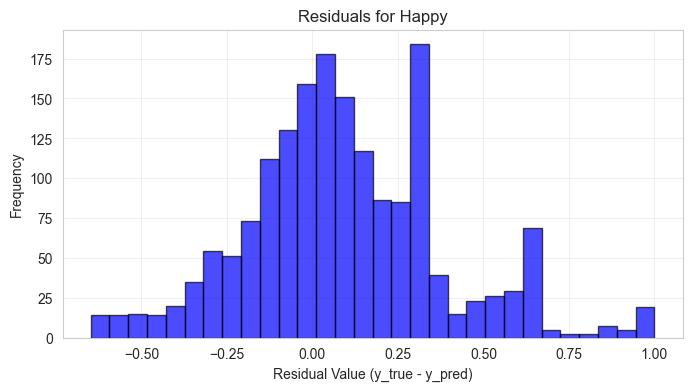

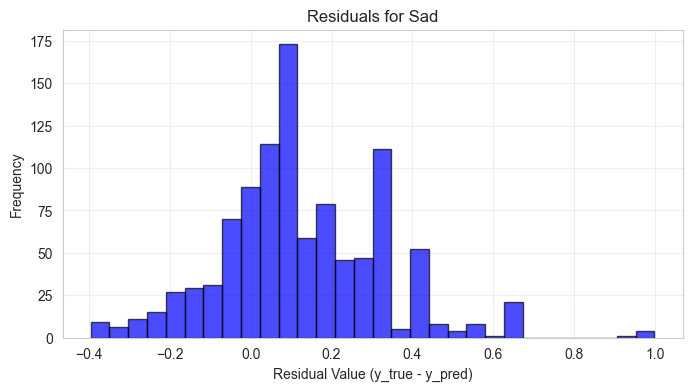

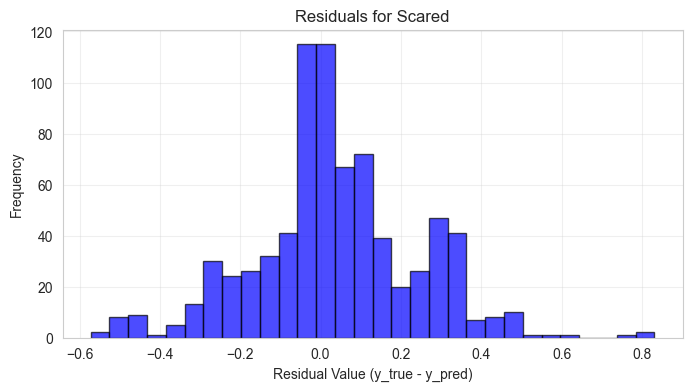

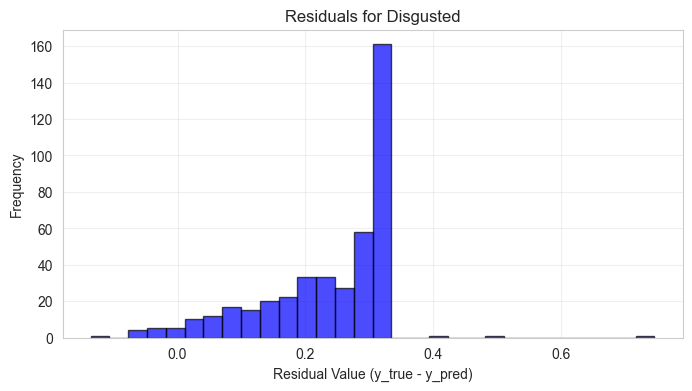

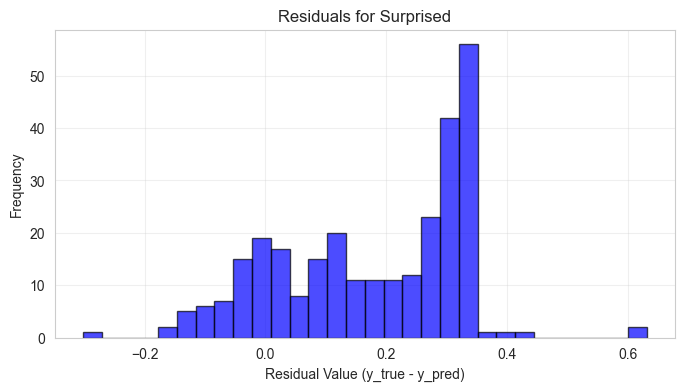

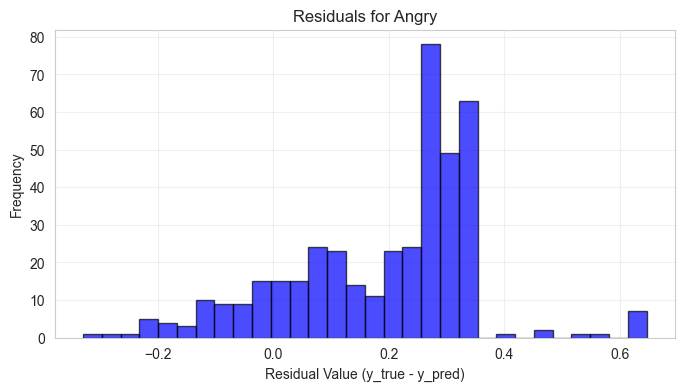

In [12]:
import matplotlib.pyplot as plt

def compute_residuals_and_plot(y_true, y_pred, emotions):
    for i, emotion in enumerate(emotions):
        # Extract true and predicted values for the specific emotion
        true_values = tf.cast(y_true[:, :, i], tf.float32)
        pred_values = tf.cast(y_pred[:, :, i], tf.float32)
        
        # Mask non-zero true values
        mask = tf.not_equal(true_values, 0)
        true_values_masked = tf.boolean_mask(true_values, mask)
        pred_values_masked = tf.boolean_mask(pred_values, mask)
        
        # Compute residuals
        residuals = true_values_masked - pred_values_masked
        
        # Plot residuals
        plt.figure(figsize=(8, 4))
        plt.hist(residuals.numpy(), bins=30, alpha=0.7, color='blue', edgecolor='black')
        plt.title(f"Residuals for {emotion}")
        plt.xlabel("Residual Value (y_true - y_pred)")
        plt.ylabel("Frequency")
        plt.grid(alpha=0.3)
        plt.show()

# Example Usage
compute_residuals_and_plot(y_true, y_pred, emotions)


In [39]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, mean_squared_error
)
from scipy.stats import ttest_ind, wilcoxon

class ModelEvaluator:
    def __init__(self, ground_truth_method_1, ground_truth_method_2, model_1_preds, model_2_probs):
        """
        Initialize the evaluator with separate ground truths and predictions for both models.

        Parameters:
        - ground_truth_method_1: Array of dominant emotion labels for Method I.
        - ground_truth_method_2: Array of emotion intensity distributions for Method II.
        - model_1_preds: Predicted class labels from Model 1 (Method I).
        - model_2_probs: Predicted probabilities from Model 2 (Method II).
        """
        self.ground_truth_method_1 = ground_truth_method_1
        self.model_1_preds = model_1_preds

        # Flatten sequence dimension for Method II
        self.ground_truth_method_2 = tf.reshape(ground_truth_method_2, [-1, ground_truth_method_2.shape[-1]]).numpy()
        self.model_2_probs = tf.reshape(model_2_probs, [-1, model_2_probs.shape[-1]]).numpy()

        # Ensure both are 2D arrays of the same shape
        assert self.ground_truth_method_2.shape == self.model_2_probs.shape, \
            "Ground truth and predicted probabilities must have the same shape."
        self.num_classes = self.model_2_probs.shape[1]


    def evaluate_method_1(self):
        """
        Evaluate Model 1 using ground truth for Method I.
        """
        metrics = {
            "accuracy": accuracy_score(self.ground_truth_method_1, self.model_1_preds),
            "precision": precision_score(self.ground_truth_method_1, self.model_1_preds, average='macro'),
            "recall": recall_score(self.ground_truth_method_1, self.model_1_preds, average='macro'),
            "f1_score": f1_score(self.ground_truth_method_1, self.model_1_preds, average='macro')
        }
        return metrics

    def evaluate_method_2(self):
        """
        Evaluate Model 2 using ground truth for Method II.
        """
        mse = mean_squared_error(self.ground_truth_method_2, self.model_2_probs)
        similarity = 1 - np.mean(np.abs(self.ground_truth_method_2 - self.model_2_probs), axis=1).mean()

        return {
            "mean_squared_error": mse,
            "similarity_score": similarity
        }

    def subset_comparison(self, subset_size=100):
        """
        Compare the models on a subset of the data.
        Parameters:
        - subset_size: Number of samples to include in the subset.
        """
        # Take subsets of available data
        ground_truth_1_subset = self.ground_truth_method_1[:subset_size]
        ground_truth_2_subset = self.ground_truth_method_2[:subset_size]
        model_1_preds_subset = self.model_1_preds[:subset_size]
        model_2_probs_subset = self.model_2_probs[:subset_size]

        # Evaluate Model 1 on the subset
        model_1_metrics = {
            "accuracy": accuracy_score(ground_truth_1_subset, model_1_preds_subset),
            "f1_score": f1_score(ground_truth_1_subset, model_1_preds_subset, average='macro')
        }

        # Evaluate Model 2 on the subset
        model_2_metrics = {
            "mse": mean_squared_error(ground_truth_2_subset, model_2_probs_subset),
            "similarity_score": 1 - np.mean(np.abs(ground_truth_2_subset - model_2_probs_subset), axis=1).mean()
        }

        return model_1_metrics, model_2_metrics

    def statistical_comparison(self):
        """
        Perform a statistical comparison of the models' outputs.
        """
        # Convert Model 2 probabilities to hard labels for comparison
        model_2_hard_preds = np.argmax(self.model_2_probs, axis=1)

        # Perform statistical test (independent as timestamps differ)
        stat, p_value = ttest_ind(self.ground_truth_method_1, model_2_hard_preds[:len(self.ground_truth_method_1)], equal_var=False)

        return {"t_statistic": stat, "p_value": p_value}

In [36]:
print(ground_truth_method_1.shape, model_1_preds.shape)


(572,) (572,)


In [40]:
ground_truth_method_1, model_1_preds = get_valid_indices(full_test_I)
model_2_probs = model_method_II.predict(full_test_II.map(lambda x, _: x))
ground_truth_method_2 = tf.concat([y for _, y in full_test_II], axis=0)

evaluator = ModelEvaluator(ground_truth_method_1, ground_truth_method_2, model_1_preds, model_2_probs)

# Evaluate models
print("Method I Metrics:", evaluator.evaluate_method_1())
print("Method II Metrics:", evaluator.evaluate_method_2())

# Subset comparison
print("Subset Comparison:", evaluator.subset_comparison(subset_size=5))

# Statistical comparison
print("Statistical Comparison:", evaluator.statistical_comparison())

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step
Method I Metrics: {'accuracy': 0.8356643356643356, 'precision': 0.786864087760164, 'recall': 0.7981508283947308, 'f1_score': 0.7895689101220907}
Method II Metrics: {'mean_squared_error': 0.020776341796862486, 'similarity_score': 0.9263983316526505}
Subset Comparison: ({'accuracy': 0.4, 'f1_score': 0.2857142857142857}, {'mse': 0.011822187482765374, 'similarity_score': 0.9335006986279041})
Statistical Comparison: {'t_statistic': 1.1613027087385261, 'p_value': 0.245780627726}
